In [1]:
pip install pandas


Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd

In [8]:
# loading both the data sets 
# Fear & Greed index
fear_greed_df = pd.read_csv(r"C:\Users\sidd2\Downloads\fear_greed_index.csv")

# Historical trader data
historical_data_df = pd.read_csv(r"C:\Users\sidd2\Downloads\historical_data.csv")


In [10]:
# checking the data set is uploaded 
print(fear_greed_df.head())

    timestamp  value classification        date
0  1517463000     30           Fear  2018-02-01
1  1517549400     15   Extreme Fear  2018-02-02
2  1517635800     40           Fear  2018-02-03
3  1517722200     24   Extreme Fear  2018-02-04
4  1517808600     11   Extreme Fear  2018-02-05


In [11]:
print(historical_data_df.head())

                                      Account  Coin  Execution Price  \
0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9769   
1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9800   
2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9855   
3  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9874   
4  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9894   

   Size Tokens  Size USD Side     Timestamp IST  Start Position Direction  \
0       986.87   7872.16  BUY  02-12-2024 22:50        0.000000       Buy   
1        16.00    127.68  BUY  02-12-2024 22:50      986.524596       Buy   
2       144.09   1150.63  BUY  02-12-2024 22:50     1002.518996       Buy   
3       142.98   1142.04  BUY  02-12-2024 22:50     1146.558564       Buy   
4         8.73     69.75  BUY  02-12-2024 22:50     1289.488521       Buy   

   Closed PnL                                   Transaction Hash     Order ID  \
0         0.0  0xec0945

In [15]:
# Convert both 'date' columns to datetime64[ns]
historical_data_df['date'] = pd.to_datetime(historical_data_df['date'])
fear_greed_df['date'] = pd.to_datetime(fear_greed_df['date'])

# Now merge again
merged_df = pd.merge(historical_data_df, fear_greed_df[['date', 'classification']], on='date', how='left')

# Check result
print(merged_df[['date', 'classification', 'Closed PnL']].head())


        date classification  Closed PnL
0 2024-12-02  Extreme Greed         0.0
1 2024-12-02  Extreme Greed         0.0
2 2024-12-02  Extreme Greed         0.0
3 2024-12-02  Extreme Greed         0.0
4 2024-12-02  Extreme Greed         0.0


In [16]:
# Group by sentiment and calculate average and total PnL
pnl_by_sentiment = merged_df.groupby('classification')['Closed PnL'].agg(['count', 'mean', 'sum']).sort_values(by='sum', ascending=False)

print(pnl_by_sentiment)


                count       mean           sum
classification                                
Fear            61837  54.290400  3.357155e+06
Extreme Greed   39992  67.892861  2.715171e+06
Greed           50303  42.743559  2.150129e+06
Neutral         37686  34.307718  1.292921e+06
Extreme Fear    21400  34.537862  7.391102e+05


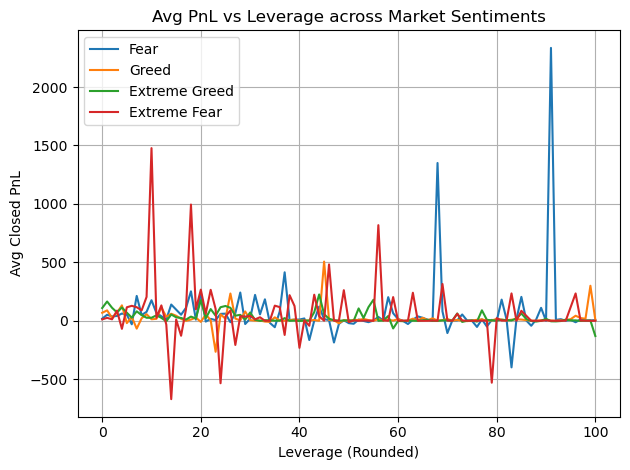

In [17]:
# Filter out extremely high leverage if needed (e.g. >100)
filtered_df = merged_df.copy()
filtered_df = filtered_df[filtered_df['Closed PnL'].notna()]

# Group by sentiment and leverage (rounded)
filtered_df['Leverage'] = (filtered_df['Size USD'] / filtered_df['Start Position']).replace([float('inf'), -float('inf')], 0)
filtered_df = filtered_df[filtered_df['Leverage'].notna() & (filtered_df['Leverage'] > 0) & (filtered_df['Leverage'] < 100)]

# Round leverage to nearest int
filtered_df['Leverage Round'] = filtered_df['Leverage'].round()

# Average PnL by sentiment and leverage
leverage_analysis = filtered_df.groupby(['classification', 'Leverage Round'])['Closed PnL'].mean().reset_index()

import matplotlib.pyplot as plt

# Plot sample (Fear and Greed)
for sentiment in ['Fear', 'Greed', 'Extreme Greed', 'Extreme Fear']:
    data = leverage_analysis[leverage_analysis['classification'] == sentiment]
    plt.plot(data['Leverage Round'], data['Closed PnL'], label=sentiment)

plt.title('Avg PnL vs Leverage across Market Sentiments')
plt.xlabel('Leverage (Rounded)')
plt.ylabel('Avg Closed PnL')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [18]:
# Group by market sentiment and side (Buy/Sell)
side_analysis = merged_df.groupby(['classification', 'Side'])['Closed PnL'].agg(['mean', 'sum', 'count']).reset_index()

print(side_analysis)


  classification  Side        mean           sum  count
0   Extreme Fear   BUY   34.114627  3.730434e+05  10935
1   Extreme Fear  SELL   34.980106  3.660668e+05  10465
2  Extreme Greed   BUY   10.498927  1.883508e+05  17940
3  Extreme Greed  SELL  114.584643  2.526821e+06  22052
4           Fear   BUY   63.927104  1.935073e+06  30270
5           Fear  SELL   45.049641  1.422082e+06  31567
6          Greed   BUY   25.002302  6.144566e+05  24576
7          Greed  SELL   59.691091  1.535673e+06  25727
8        Neutral   BUY   29.227429  5.544151e+05  18969
9        Neutral  SELL   39.456408  7.385056e+05  18717
